In [21]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
#from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Management

In [18]:
# Data Extraction
symbol = "TATAMOTORS.NS"
symbol_name = "TATAMOTORS"
df = pd.read_csv("data/{}.csv".format(symbol))
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-16,0.005720,-1.713511e-07,-0.020040,79.029312,0.036689,-0.030933,0.042945,0.055075,47.715545,0.811497,...,78.437493,2,-0.051231,0.032276,-0.001574,0.022044,0.989009,0.008531,0.018471,1.041721
2005-02-17,-0.034124,-3.431362e-02,-0.152556,78.507118,0.013127,-0.006608,0.188465,0.091864,45.791304,0.959673,...,78.558002,3,-0.056590,0.038046,-0.030933,0.042945,0.811497,-0.001574,0.022044,0.989009
2005-02-18,0.033503,3.756350e-02,0.148890,76.900345,-0.090076,-0.020467,0.073304,0.091641,40.393484,0.882121,...,78.637575,4,-0.046083,0.037757,-0.006608,0.188465,0.959673,-0.030933,0.042945,0.811497


In [5]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [6]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,-0.017544,-0.003764,0.000179,567.849976,-0.253781,0.014652,0.020079,115394.085049,60.577488,1.066252,...,0,0.070531,0.021437,-0.017037,0.024117,0.895123,-0.020726,0.029039,0.864846,0.0
2023-06-27,0.017857,0.013884,0.019093,573.099976,0.346066,0.009245,0.014865,116460.958735,62.812262,1.036891,...,1,0.098049,0.020834,0.014652,0.020079,1.066252,-0.017037,0.024117,0.895123,0.0
2023-06-29,0.005439,-0.006587,0.008180,573.099976,-1.000000,0.000000,0.000000,119559.972775,62.812262,1.000000,...,3,0.108890,0.020089,0.009245,0.014865,1.036891,0.014652,0.020079,1.066252,0.0
2023-06-30,0.026610,0.045193,0.025999,595.549988,inf,0.039173,0.018707,125171.896041,70.972834,1.129920,...,4,0.161739,0.019806,0.000000,0.000000,1.000000,0.009245,0.014865,1.036891,1.0
2023-07-03,0.019801,0.005509,0.003401,590.799988,-0.108664,-0.007976,0.020847,124930.196352,67.593082,0.952380,...,0,0.121312,0.019071,0.039173,0.018707,1.129920,0.000000,0.000000,1.000000,0.0


### Train Test Split

In [7]:
# Feature Selection
df_tts = df.copy()
df_tts = df_tts[[ "Range", "RSI", "RSI_Ret", "Avg_Range", "RSI_Ret_T1", "TARGET"]]

In [9]:
# Split into X and Y Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [10]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (3175, 5)
Shape of y_train:  (3175,)
Shape of X_test:  (1361, 5)
Shape of y_test:  (1361,)
Size Matches:  True


### Build Model

In [11]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [12]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [13]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [14]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
# ne: 1#15, lr: 0.2 md: 5 gm: 20
#Recommended Params >> ne: 65, lr: 0.05 md: 1 gm: 20

ne = 65
lr = 0.05
md = 1
gm = 20

In [15]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [16]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.set_params(eval_metric=eval_metric_list)  # Example metric: 'error'

classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [22]:
# Save the trained model to a file
with open('../TrainedModel/xg/{}_model_2.pkl'.format(symbol_name), 'wb') as f:
    pickle.dump(classifier, f)

In [37]:
X_train

,Range,RSI,RSI_Ret,Avg_Range,RSI_Ret_T1
Date,,,,,
2005-02-16,0.042945,47.715545,0.811497,0.032276,0.989009
2005-02-17,0.188465,45.791304,0.959673,0.038046,0.811497
2005-02-18,0.073304,40.393484,0.882121,0.037757,0.959673
2005-02-21,0.026261,39.589380,0.980093,0.037256,0.882121
2005-02-22,0.017643,44.291907,1.118783,0.037049,0.980093
...,...,...,...,...,...
2017-12-20,0.020274,57.655712,1.029178,0.023915,1.253883
2017-12-21,0.015493,56.040631,0.971987,0.022454,1.029178
2017-12-22,0.013067,56.907292,1.015465,0.021386,0.971987


### Make Predictions

In [23]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [1 0 1 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.45764464 0.54235536]
 [0.5714369  0.42856312]
 [0.4562292  0.5437708 ]]


In [24]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.6240117  0.3759883 ]
 [0.55614877 0.44385126]
 [0.5284686  0.47153142]]


In [25]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [26]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

### Evaluation Metrics  - Loss and Overfitting

In [27]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

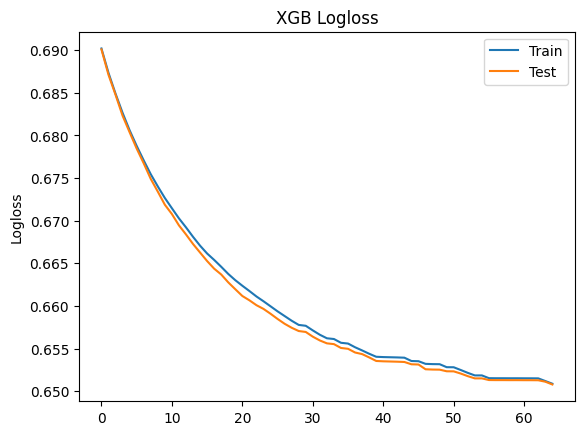

In [28]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

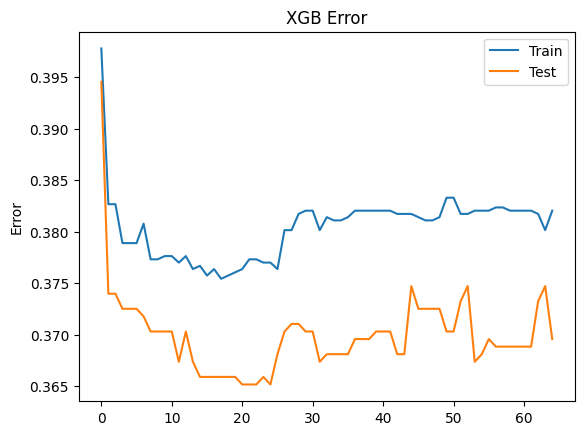

In [29]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

In [22]:
# Plot Training ROC Curve
#plot_roc_curve(classifier, X_train, y_train)

In [23]:
# Plot Test ROC Curve
#plot_roc_curve(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [30]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [31]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.62
Std Dev K-Fold 0.06
Precision Score 0 0.619
Precision Score 1 0.602
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.5
Std Dev K-Fold 0.26
Precision Score 0 0.628
Precision Score 1 0.66



### Evaluation Metrics - Summary Report

In [33]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.62      0.95      0.75      1912
         1.0       0.60      0.12      0.20      1263

    accuracy                           0.62      3175
   macro avg       0.61      0.53      0.47      3175
weighted avg       0.61      0.62      0.53      3175



In [34]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.63      0.96      0.76       824
         1.0       0.66      0.13      0.22       537

    accuracy                           0.63      1361
   macro avg       0.64      0.54      0.49      1361
weighted avg       0.64      0.63      0.54      1361



### Performance Evaluation - Confusion Matrix

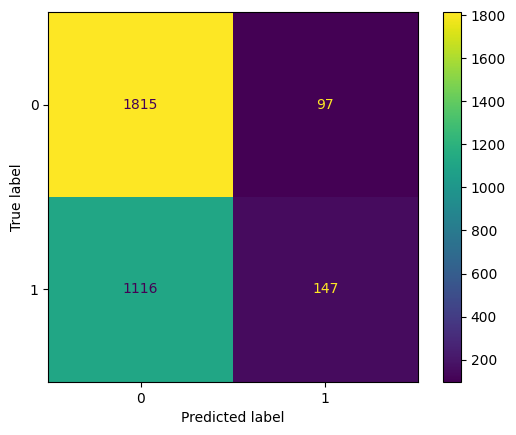

In [35]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

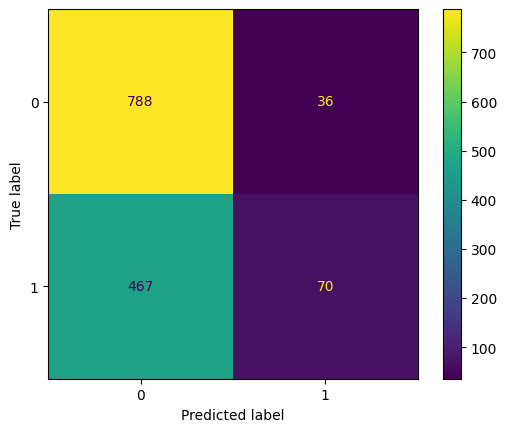

In [36]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

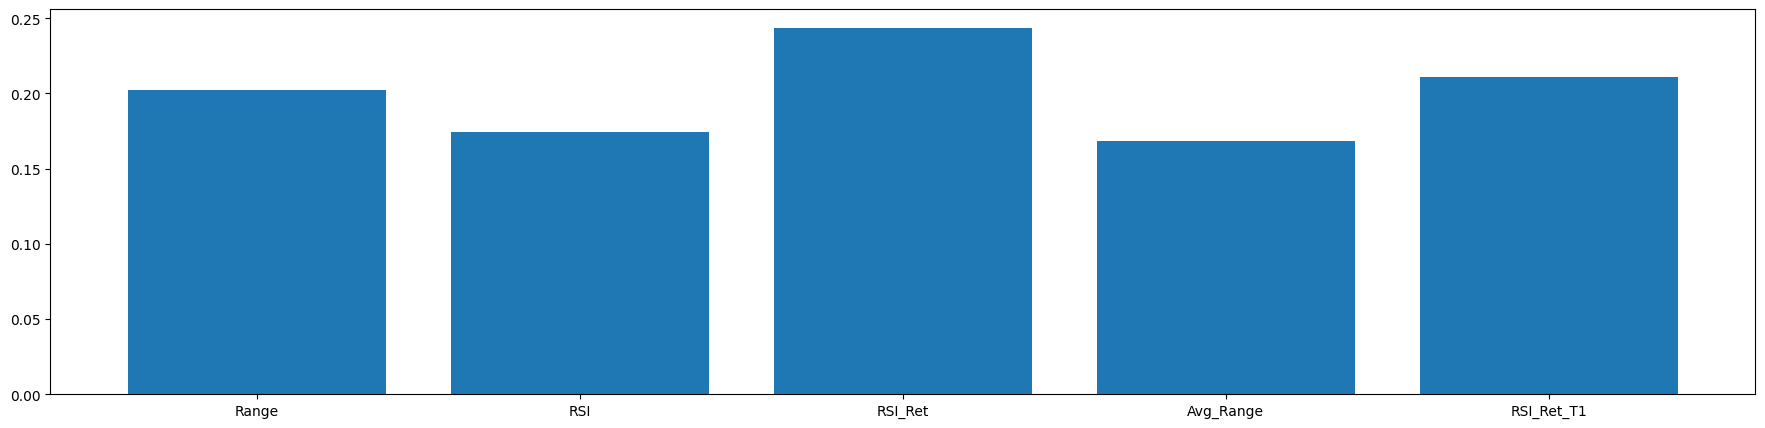

In [33]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [32]:
#conda install graphviz python-graphviz

### XGBOOST TREE

<Axes: >

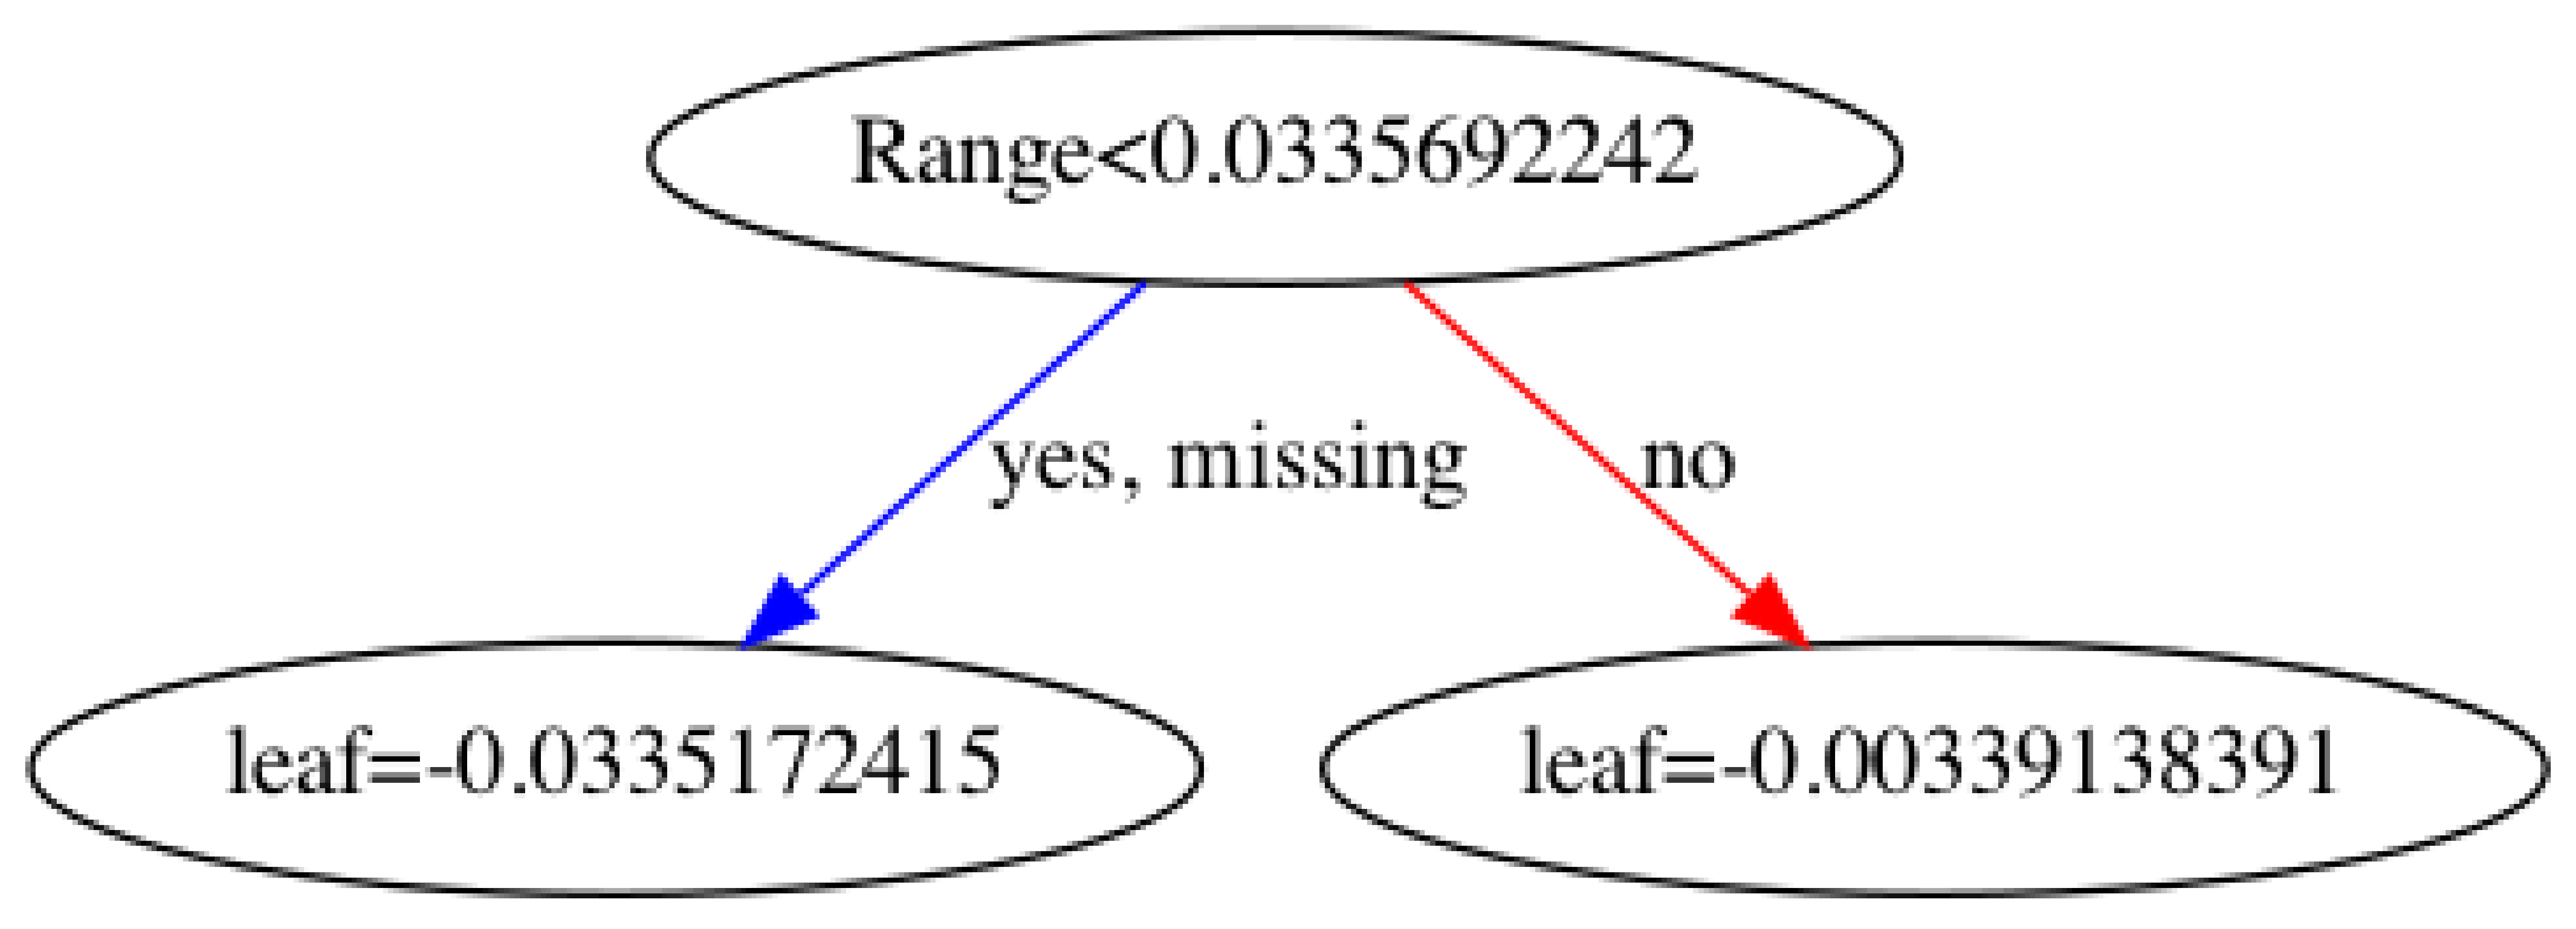

In [34]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)

### Conclusion

We feel that it is possible using Machine Learning, that we can forecast with better than 50/50 odds, whether the Range (our interpretation of volatility) for Bitcoin, can be predicted ahead of of time by at least 1 day into the future. This information could be valuable for MOVE based contracts trading.